# Exploratory Data Analysis

### Andrew Larimer, Deepak Nagaraj, Daniel Olmstead, Michael Winton

#### W207-4-Summer 2018 Final Project

[Return to project overview](final_project_overview.ipynb)

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import util

# set default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Get train-test split
train_data, test_data, train_labels, test_labels = util.read_data()
# convert train_labels into a dataframe in order to concatenate it
train_labels_df = pd.DataFrame(train_labels)
train_labels_df.columns=['high_registrations']

# Concatenate training features and labels into one dataframe
Xy_train = pd.concat([train_data, train_labels_df], axis=1)

Train: 371 observations (positive class fraction: 0.232)
Test : 93 observations (positive class fraction: 0.226)


## Verifying correlation between "equivalent" percent and rating columns
The definitions of these "percent" and "rating" columns on Kaggle are identical, leading us to question whether these were duplicate columns, so we plotted them against each other. 

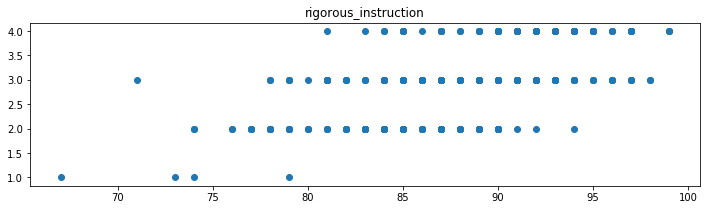

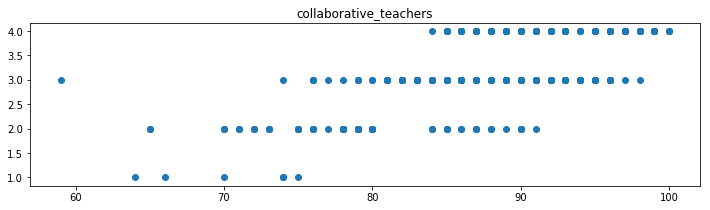

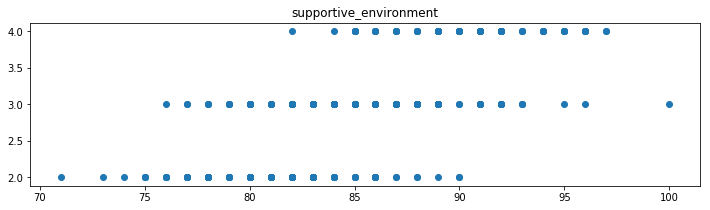

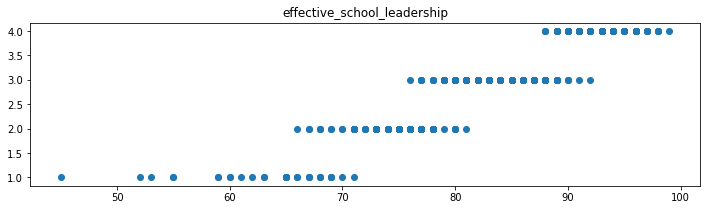

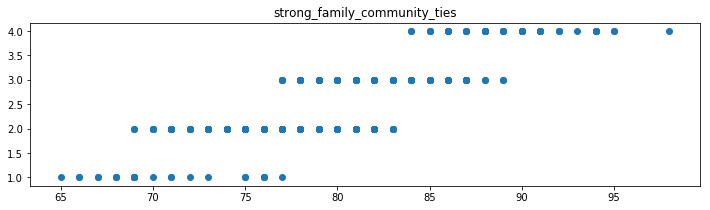

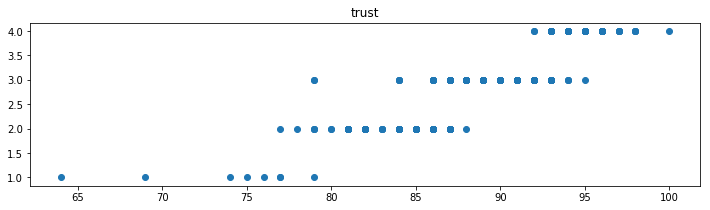

In [2]:
plt.rcParams['figure.figsize'] = [12, 3]
plt.scatter(train_data['rigorous_instruction_percent'], train_data['rigorous_instruction_rating'])
plt.title('rigorous_instruction')
plt.show()
plt.scatter(train_data['collaborative_teachers_percent'], train_data['collaborative_teachers_rating'])
plt.title('collaborative_teachers')
plt.show()
plt.scatter(train_data['supportive_environment_percent'], train_data['supportive_environment_rating'])
plt.title('supportive_environment')
plt.show()
plt.scatter(train_data['effective_school_leadership_percent'], train_data['effective_school_leadership_rating'])
plt.title('effective_school_leadership')
plt.show()
plt.scatter(train_data['strong_family_community_ties_percent'], train_data['strong_family_community_ties_rating'])
plt.title('strong_family_community_ties')
plt.show()
plt.scatter(train_data['trust_percent'], train_data['trust_rating'])
plt.title('trust')
plt.show()

It turns out we cannot consider the `percent` and `rating` columns to be duplicates because, for example an 85% on most plots could be a 2, 3, or 4 rating.  They are correlated, but are not perfectly multicollinear; as a result, we will keep both sets of features in the dataset.

## Correlation Matrix: key non-demographic features

As we expect many of our features to be highly correlated, looking at a visual representation of the correlation matrix is a useful step in our EDA.  In this first plot, we intentionally omit features either directly representing, or closely related to demographic features.  

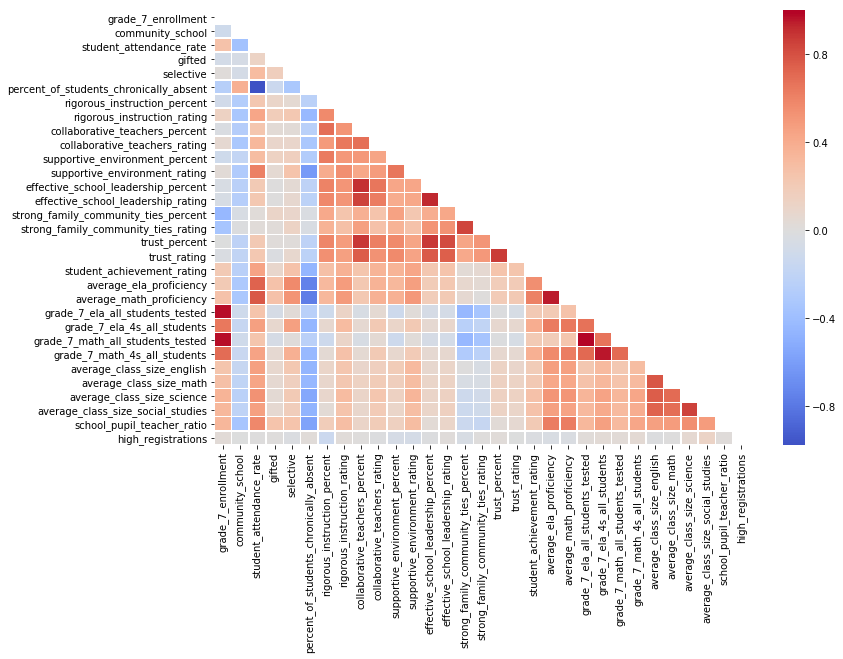

In [3]:
%matplotlib inline

# choose key features for correlation matrix
corr_features = ['grade_7_enrollment',
                 'community_school', 
                 'student_attendance_rate',
                 'gifted',
                 'selective',
                 'percent_of_students_chronically_absent',
                 'rigorous_instruction_percent', 
                 'rigorous_instruction_rating', 
                 'collaborative_teachers_percent', 
                 'collaborative_teachers_rating', 
                 'supportive_environment_percent',
                 'supportive_environment_rating',
                 'effective_school_leadership_percent',
                 'effective_school_leadership_rating',
                 'strong_family_community_ties_percent',
                 'strong_family_community_ties_rating',
                 'trust_percent',
                 'trust_rating',
                 'student_achievement_rating',
                 'average_ela_proficiency',
                 'average_math_proficiency',
                 'grade_7_ela_all_students_tested',
                 'grade_7_ela_4s_all_students',
                 'grade_7_math_all_students_tested',
                 'grade_7_math_4s_all_students',
                 'average_class_size_english', 
                 'average_class_size_math',
                 'average_class_size_science',
                 'average_class_size_social_studies',
                 'school_pupil_teacher_ratio',
                 'high_registrations']


def draw_heatmap(df, fig_name):
    corr_matrix = df.corr(method='pearson')
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    # plot heatmap and also save to disk
    plt.rcParams['figure.figsize'] = [12, 8]
    sns.heatmap(corr_matrix, annot=False, fmt="g",
                xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,
                center=0, linewidths=0.5, cmap="coolwarm", mask=mask)
    plt.savefig(fig_name, bbox_inches='tight')

draw_heatmap(Xy_train[corr_features], 'plots/corr_matrix_key_features.png')

From this correlation matrix, we see that unfortunately most features show almost no correlation with a high SHSAT registration rate.  The rigorous intruction % score, as well as the supportive environment % score show weak negative correlations with registration rate. Several other features (e.g. average social studies class size) show a very weak positive correlation.

#### Interesting correlations
* Proficiency in both ELA and math is strongly correlated with strong attendance rate
* Conversely, proficiency is strongly negatively correlated with low attendance schools (% chronically absent).  _It may be that improving attendance gives the most "bang for the buck" in terms of performance._
* Math and ELA proficiency have high correlation: in other words, schools tend to have students proficient in both of them, rather than just one.
* Both math and ELA proficiency are moderately correlated with pupil:teacher ratio: this is surprising, because we would expect proficiency to go down as the ratio goes up.  This may be because of peer group and competitive effects.
* Collaborative teachers, effective school leadership, and trust percentage are highly correlated between each other.  It seems as if they occur together.  _But they don't seem to have any correlation with high registrations._
* Community schools are negatively correlated with proficiency.  This is probably due to a hidden variable:  they are located in neighborhoods that are not conducive for student performance.  By definition, community schools are "designed to counter environmental factors that impede student achievement".  _This also is an opportunity to consider._
* Class sizes in English, Math and Science are all highly correlated.  It seems like we can use one to represent all.

## Correlation Matrix: demographic features

As the lack of diversity in the SHSAT registrations is part of our original problem statement, it is also interesting to look at the existing correlation between demographic-related features and test registrations.

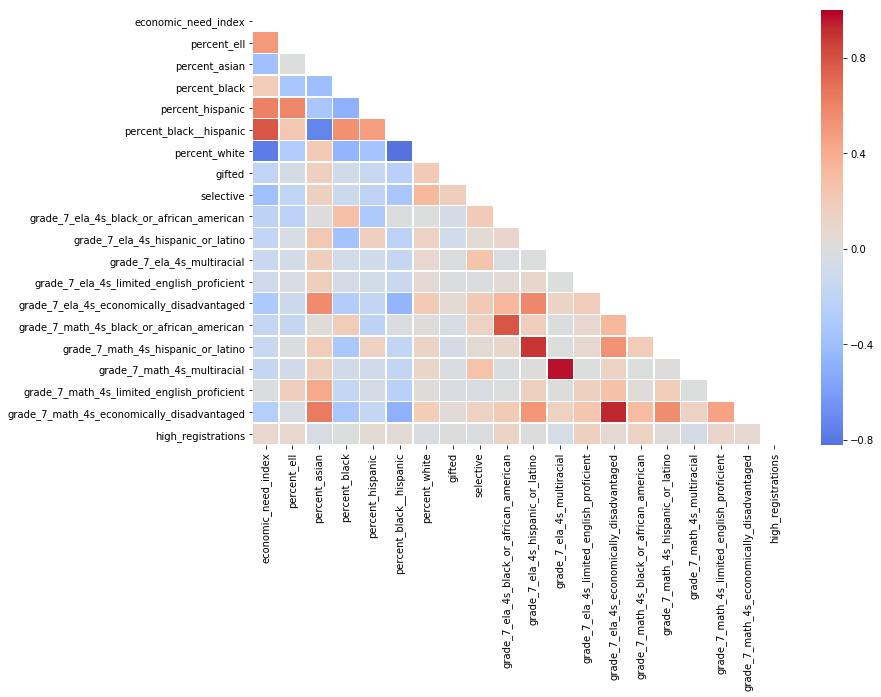

In [4]:
# choose key features for correlation matrix
demog_features =  ['economic_need_index',
                   'percent_ell',
                   'percent_asian',
                   'percent_black', 
                   'percent_hispanic', 
                   'percent_black__hispanic',
                   'percent_white',
                   'gifted',
                   'selective',
                   'grade_7_ela_4s_black_or_african_american',
                   'grade_7_ela_4s_hispanic_or_latino',
                   'grade_7_ela_4s_multiracial',
                   'grade_7_ela_4s_limited_english_proficient',
                   'grade_7_ela_4s_economically_disadvantaged',
                   'grade_7_math_4s_black_or_african_american',
                   'grade_7_math_4s_hispanic_or_latino',
                   'grade_7_math_4s_multiracial',
                   'grade_7_math_4s_limited_english_proficient',
                   'grade_7_math_4s_economically_disadvantaged',
                   'high_registrations']

draw_heatmap(Xy_train[demog_features], 'plots/corr_matrix_demographics.png')

We see that surprisingly, percent Asian and percent white have a weak negative correlation with high SHSAT registration rates, whereas percent black, Hispanic, and ELL have weak positive correlations with the SHSAT registration rate.  It is particularly interesting to note that schools with a high proportion of economically disadvantaged students, limited English proficiency students, and black students scoring 4's on their ELA and Math exams tend to have higher registration rates, as well.  This is promising, as it seems to support PASSNYC's mission.

#### Interesting correlations

* Schools with high number of Hispanics also tend to have high economic need index
* Schools with high number of Hispanics also tend to have high English learners
* On the contrary, schools with high number of whites have low economic need index
* Schools with high number of blacks and Hispanics tend not to have Asians, indicating segregation
* Schools with high number of Asian students also tend to have a higher number of 4's for both Math and English for economically disadvantaged students.
* Schools with high number of blacks tend not to have whites or Hispanics, again indicating segregation
* Schools tend to have high performers in both ELA and math, not just one of them.

## Correlation Matrix: location and economic features

We would also like to look at the correlation between high registration rate and the boroughs and economic variables.

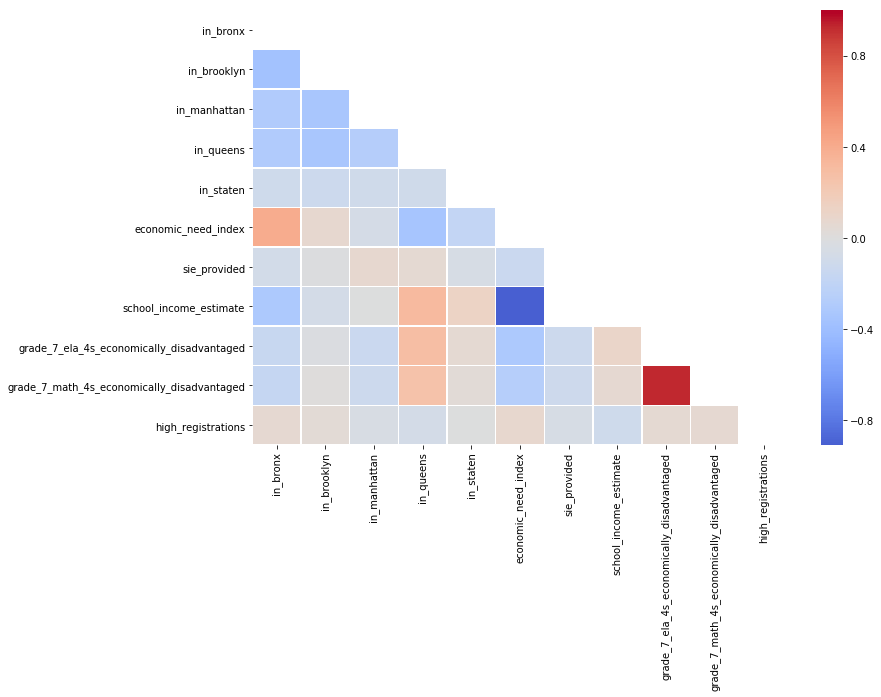

In [5]:
# choose key features for correlation matrix
geo_econ_features =  ['in_bronx',
                      'in_brooklyn',
                      'in_manhattan',
                      'in_queens',
                      'in_staten',
                      'economic_need_index',
                      'sie_provided',
                      'school_income_estimate',
                      'grade_7_ela_4s_economically_disadvantaged',
                      'grade_7_math_4s_economically_disadvantaged',
                      'high_registrations']

draw_heatmap(Xy_train[geo_econ_features], 'plots/corr_matrix_boroughs.png')

We observe from this correlation matrix that the demographic and economic features in general are not strongly correlated with a high SHSAT registration rate.  There are very slight positive correlations for students in the Bronx or Brooklyn, as well as with the economic need index.  There is a slight negative correlation with SHSAT registration rate for students in Queens.  As such, we expect it will be unlikely that the indicator variables for the boroughs will have strong predictive value.

We also see a negative correlation between school income estimate and high SHSAT registration rate, but caution that we only have these income estimates for about 1/3 of the schools in our dataset.  Contrary to our hypothesis that the existence or non-existence of such a school income estimate for a particular school might be meaningful, the binary flag for whether a school provided an income estimate seems uncorrelated with registration rate.

### Outlier Analysis

Let us look at the distribution of test taker percentage across NYC schools.

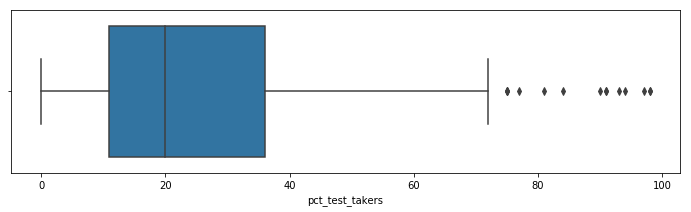

In [6]:
plt.rcParams['figure.figsize'] = [12, 3]
sns.boxplot(x=train_data['pct_test_takers'])
plt.show()

There are quite a few outliers there.  Let us look at them.

In [7]:
display(train_data[train_data['pct_test_takers'] >= 80].sort_values('pct_test_takers', ascending=False))

,dbn,grade_7_enrollment,num_shsat_test_takers,offers_per_student,pct_test_takers,school_name,district,zip,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black__hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_limited_english_proficient,grade_7_math_4s_economically_disadvantaged,sie_provided,in_bronx,in_brooklyn,in_manhattan,in_queens,in_staten,number_of_students_english,number_of_students_math,number_of_students_science,number_of_students_social_studies,number_of_classes_english,number_of_classes_math,number_of_classes_science,number_of_classes_social_studies,average_class_size_english,average_class_size_math,average_class_size_science,average_class_size_social_studies,school_pupil_teacher_ratio,gifted,selective
21,03M334,64,75,76,98,THE ANDERSON SCHOOL,3,10024,0,0.134,89026.73,0,28,4,9,13,53,98.0,1.0,90.0,4.0,90.0,4.0,92.0,4.0,87.0,3.0,93.0,4.0,92.0,3.0,4.0,3.93,4.15,72,50,0,0,0,13,30,0,0,4,72,59,0,0,0,0,39,0,0,3,1,0,0,1,0,0,229.0,214.0,214.0,214.0,9.0,8.0,8.0,8.0,25.444444,26.750000,26.750000,26.750000,20.9,1,1
28,30Q122,94,74,65,98,P.S. 122 MAMIE FAY,30,11105,0,0.421,54818.42,5,30,6,21,27,39,96.0,8.0,90.0,4.0,86.0,4.0,91.0,3.0,71.0,2.0,78.0,2.0,92.0,3.0,4.0,3.38,3.52,84,59,0,0,0,37,13,0,0,32,84,58,0,0,0,40,10,0,0,33,1,0,0,0,1,0,273.0,273.0,273.0,273.0,10.0,10.0,10.0,10.0,27.300000,27.300000,27.300000,27.300000,18.7,1,0
105,18K235,92,89,8,97,P.S. 235 JANICE MARIE KNIGHT SCHOOL,18,11203,0,0.520,48361.64,1,2,93,2,95,2,95.0,11.0,92.0,3.0,94.0,3.0,86.0,3.0,90.0,4.0,83.0,3.0,93.0,3.0,4.0,3.05,3.10,112,38,0,0,0,0,0,0,0,28,112,37,0,0,0,0,0,0,0,31,1,0,1,0,0,0,307.0,307.0,307.0,307.0,11.0,11.0,11.0,11.0,27.909091,27.909091,27.909091,27.909091,18.2,1,0
29,20K686,58,80,54,94,BROOKLYN SCHOOL OF INQUIRY,20,11218,0,0.209,65859.29,6,18,5,5,10,71,96.0,5.0,91.0,4.0,97.0,4.0,94.0,4.0,95.0,4.0,90.0,4.0,95.0,4.0,3.0,3.47,3.68,50,24,0,0,0,0,22,0,0,4,50,37,0,0,0,4,31,0,0,7,1,0,1,0,0,0,213.0,213.0,213.0,213.0,7.0,7.0,7.0,7.0,30.428571,30.428571,30.428571,30.428571,20.5,1,1
455,06M223,104,81,0,93,THE MOTT HALL SCHOOL,6,10027,0,0.724,NaN,4,1,9,84,93,4,94.0,16.0,92.0,3.0,88.0,2.0,87.0,3.0,80.0,2.0,73.0,2.0,90.0,3.0,4.0,3.01,3.12,82,12,0,0,10,0,0,0,0,10,81,14,0,0,13,0,0,0,0,11,0,0,0,1,0,0,395.0,287.0,285.0,287.0,18.0,13.0,13.0,12.0,21.944444,22.076923,21.923077,23.916667,13.0,0,1
0,20K187,266,251,75,91,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,20,11219,0,0.480,NaN,2,69,1,6,7,24,98.0,2.0,92.0,4.0,91.0,4.0,92.0,4.0,90.0,4.0,76.0,2.0,93.0,4.0,4.0,3.83,4.19,324,226,0,0,0,154,61,0,0,121,324,304,0,0,0,206,83,0,0,166,0,0,1,0,0,0,1052.0,934.0,1385.0,1313.0,42.0,37.0,49.0,46.0,25.047619,25.243243,28.265306,28.543478,17.6,0,1
2,03M054,295,257,53,91,J.H.S. 054 BOOKER T. WASHINGTON,3,10025,0,0.221,NaN,2,9,8,12,20,64,96.0,5.0,85.0,NaN,83.0,NaN,87.0,NaN,80.0,2.0,84.0,3.0,90.0,3.0,4.0,3.46,3.70,250,1

### NYC "Gifted & Talented" Program

We tried to analyze why these schools have such high enrollments.  When we did some research on the Internet, we found that New York actually has a "Gifted & Talented" Test that kids can take.  High-performers can go into "G&T Schools".  It is these schools that are the outliers above.

* The Anderson School: A "Gifted and Talented" school: "has an advanced math program, with fast-paced instruction, which encourages students to discover new approaches to math problems". [Source](https://www.testingmom.com/tests/gifted-talented-nyc/schools/).

* Mamie Fay: Has a "gifted and talented" [program](https://insideschools.org/school/30Q122).

* Janice Marie Knight: This school seems to be a clear outlier: it has 93% black student population, yet it has 97% SHSAT registration.  Turns out it has a gifted program called [SOAR](https://insideschools.org/school/18K235).

* Tag Young Scholars: The school explicitly identifies itself for [excellence](http://tagscholars.com/index.php/mission-statement/).

* G&T Citywide (30th Ave): The name says it all: "Gifted and Talented".

* Brooklyn School of Inquiry: [Gifted](https://insideschools.org/school/20K686) school.

* Booker T. Washington: Very [selective in admissions](https://insideschools.org/school/03M054).

* Christa Mcauliffe: Strong [special education program](https://insideschools.org/school/20K187).

* New York City Lab Middle School: [Very selective](https://insideschools.org/school/02M312).